# Lab 3b: Ensembles
## Using trees to detect trees 

We will be using tree-based ensemble methods on the [Covertype dataset](https://www.openml.org/d/180).
It contains about 100,000 observations of 7 types of trees (Spruce, Pine, Cottonwood, Aspen,...) described by 55 features describing elevation, distance to water, soil type, etc.

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [2]:
# Download Covertype data. Takes a while the first time.
covertype = oml.datasets.get_dataset(180)
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array'); 
classes = covertype.retrieve_class_labels()
features = [f.name for i,f in covertype.features.items()][:-1]

In [3]:
classes

['Aspen',
 'Cottonwood_Willow',
 'Douglas_fir',
 'Krummholz',
 'Lodgepole_Pine',
 'Ponderosa_Pine',
 'Spruce_Fir']

In [4]:
features[0:20]

['elevation',
 'aspect',
 'slope',
 'horizontal_distance_to_hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'wilderness_area1',
 'wilderness_area2',
 'wilderness_area3',
 'wilderness_area4',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6']

To understand the data a bit better, we can use a scatter matrix. From this, it looks like elevation is a relevant feature.
Douglas Fir and Aspen grow at low elevations, while only Krummholz pines survive at very high elevations.

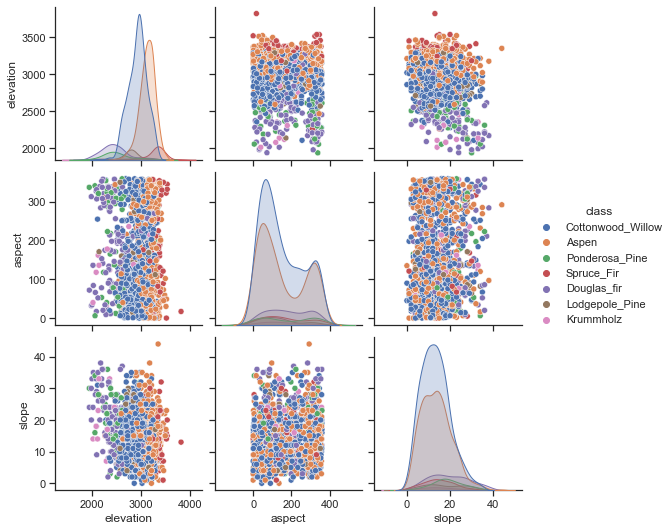

In [5]:
# Using seaborn to build the scatter matrix
# only first 3 columns, first 1000 examples
n_points = 1500
df = pd.DataFrame(X[:n_points,:3], columns=features[:3])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class");

## Exercise 1: Random Forests
Implement a function `evaluate_RF` that measures the performance of a Random Forest Classifier, using trees
of (max) depth 2,8,32,64, for any number of trees in the ensemble (`n_estimators`). 
For the evaluation you should measure accuracy using 3-fold cross-validation. 
Use `random_state=1` to ensure reproducibility. Finally, plot the results for at least 5 values of `n_estimators` ranging from 1 to 30. You can, of course, reuse code from earlier labs and assignments. Interpret the results.
You can take a 50% subsample to speed the plotting.

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:57<00:00,  9.52s/it]


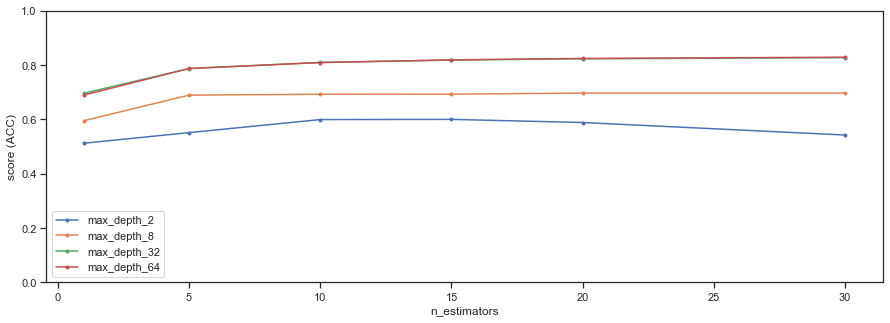

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def evaluate_RF(X, y,n_estimators,score, max_depths = [2,8,32,64]):
    results = {}
    for depth in max_depths:
        rf = RandomForestClassifier(n_estimators, max_depth=depth, random_state=1)
        results['max_depth_{}'.format(depth)] = np.mean(cross_val_score(rf, X, y, cv=3, scoring=score))
    
    return results

def plot_results_rf(X, y, score = "accuracy"):
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.5)
    
    fig, ax = fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    n_est_param = [1, 5, 10, 15, 20, 30]
    plot_series = {}
    for n_est in tqdm(n_est_param):
        scores = evaluate_RF(Xs, ys, n_est, score=score)
        
        if len(plot_series.keys()) == 0:
            for k in scores.keys():
                plot_series[k] = [scores[k]]
        
        else:
            for k in scores.keys():
                plot_series[k].append(scores[k])

    
    for k in plot_series.keys():
        ax.plot(n_est_param, plot_series[k], marker = '.', label = k)
    ax.set_ylabel('score (ACC)')
    ax.set_ylim((0,1))
    ax.set_xlabel("n_estimators")
    ax.legend()
    

plot_results_rf(X, y)  

In general more trees are better, max depth of 32 and 64 work best.

## Exercise 2: Other measures
Repeat the same plot but now use balanced_accuracy as the evaluation measure. See the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).
Only use the optimal max_depth from the previous question. Do you see an important difference?

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:57<00:00,  9.56s/it]


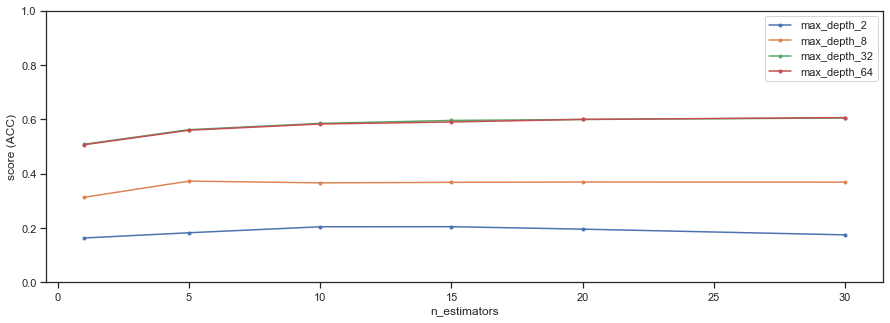

In [26]:
plot_results_rf(X,y,score="balanced_accuracy")

No big difference.

## Exercise 3: Feature importance
Retrieve the feature importances according to the (tuned) random forest model. Which feature are most important?

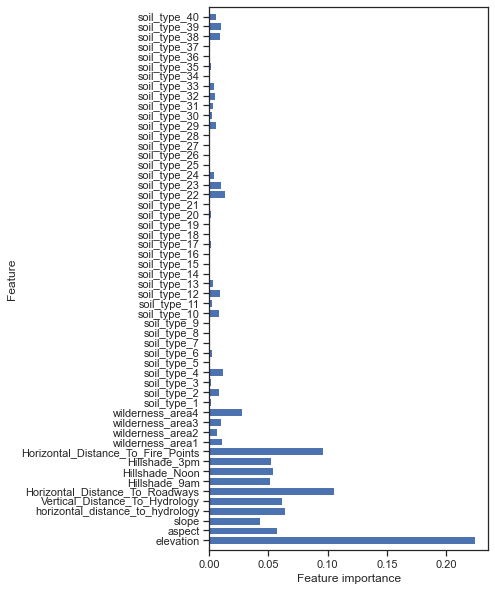

In [44]:
def plot_feature_importances(features, model):
    n_features = len(features)
    plt.figure(figsize=(5,10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(range(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

rf = RandomForestClassifier(n_estimators=20, max_depth=32, random_state=1).fit(X,y)
plot_feature_importances(features,rf)

## Exercise 4: Feature selection
Re-build your tuned random forest, but this time only using the first 10 features.
Return both the balanced accuracy and training time. Interpret the results.

In [50]:
import time
top10_feat = np.argpartition(rf.feature_importances_, -10)[-10:]
Xs = X[:,top10_feat]
start = time.time()
score = evaluate_RF(X, y, n_estimators=20, max_depths=[32], score='balanced_accuracy')
print("Normal RF: {:.2f} balanced ACC, {:.2f} seconds".format(score['max_depth_32'], (time.time()-start)))

start = time.time()
score = evaluate_RF(Xs, y, n_estimators=20, max_depths=[32], score='balanced_accuracy')
print("Feature Selection RF: {:.2f} balanced ACC, {:.2f} seconds".format(score['max_depth_32'], (time.time()-start)))

Normal RF: 0.65 balanced ACC, 11.36 seconds
Feature Selection RF: 0.62 balanced ACC, 13.19 seconds


## Exercise 5: Confusion matrix
Do a standard stratified holdout and generate the confusion matrix of the tuned random forest. Which classes are still often confused?

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)
rf = RandomForestClassifier(n_estimators=20, max_depth=32).fit(X_train, y_train)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rf.predict(X_test))

array([[ 8500,  1076,    38,    17,    21,    15,    60],
       [  720, 11986,    78,    25,    34,    44,    34],
       [   90,   174,  1489,     7,    10,    65,     9],
       [   80,   108,    34,    98,     2,     8,     5],
       [  104,   269,    20,     0,   245,     7,     8],
       [   84,   173,   134,     4,     5,   583,     9],
       [  204,   119,    14,     3,     8,     7,   772]], dtype=int64)

The first and second class are confused most often.

## Exercise 6: A second-level model
Build a binary model specifically to correctly choose between the first and the second class.
Select only the data points with those classes and train a new random forest. Do a standard stratified split and plot the resulting ROC curve. Can we still improve the model by calibrating the threshold?

In [100]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
X_01 = X[np.isin(y, [0,1]), :]
y_01 = y[np.isin(y, [0,1])]
X_train, X_test, y_train, y_test = train_test_split(X_01,y_01, stratify=y_01)
rf_bin = RandomForestClassifier(n_estimators=20, max_depth=32).fit(X_train, y_train)

confusion_matrix(y_test, rf.predict(X_test))

array([[ 9415,   312],
       [  203, 12717]], dtype=int64)

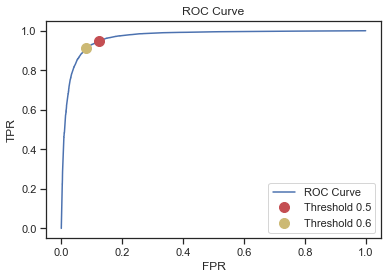

In [90]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
fig, ax = plt. subplots(1,1)
ax.plot(fpr, tpr, label='ROC Curve')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC Curve")
default_thresh = np.argmin(np.abs(thresholds-0.5))
new_thresh = np.argmin(np.abs(thresholds-0.6)) # Increase the threshold slightly to get to left top corner
ax.plot(fpr[default_thresh], tpr[default_thresh], 'ro', markersize=10, label='Threshold 0.5')
ax.plot(fpr[new_thresh], tpr[new_thresh], 'yo', markersize=10, label='Threshold 0.6')
ax.legend();

Legend was slightly improved by increasing the threshold

## Exercise 7: Model calibration
For the trained binary random forest model, plot a calibration curve (see [course notebook](https://ml-course.github.io/engineer/slides_html/03%20-%20Model%20Selection.slides.html#/40)). 
Next, try to correct for this using Platt Scaling (or sigmoid scaling).

Probability calibration should be done on new data not used for model fitting. The class [CalibratedClassifierCV](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) uses a cross-validation generator and estimates for each split the model parameter on the train samples and the calibration of the test samples. The probabilities predicted for the folds are then averaged. Already fitted classifiers can be calibrated by CalibratedClassifierCV via the parameter cv=”prefit”. [Read more](https://scikit-learn.org/stable/modules/calibration.html)

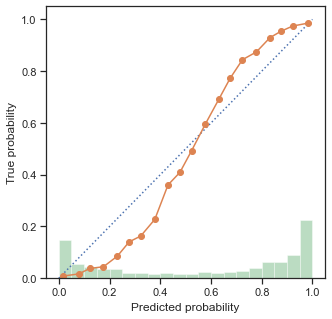

In [119]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

def plot_calibration_curve(X, y, model, n_bins=5):
    y_prob = model.predict_proba(X)[:,1]
    prob_true, prob_predict = calibration_curve(y, y_prob, n_bins=n_bins)
    
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot([0,1], [0,1], ':')
    ax.plot(prob_predict, prob_true, marker="o")
    
    ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4, bins=np.maximum(10,n_bins))
    
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("True probability")
    

X_bin = X[np.isin(y, [0,1]), :]
y_bin = y[np.isin(y, [0,1])]
X_train, X_test, y_train, y_test = train_test_split(X_bin,y_bin, stratify=y_bin, random_state=1)
rf_bin = RandomForestClassifier(random_state=0,n_estimators=25, max_depth=32).fit(X_train, y_train)
plot_calibration_curve(X_test, y_test, rf_bin, n_bins=20)

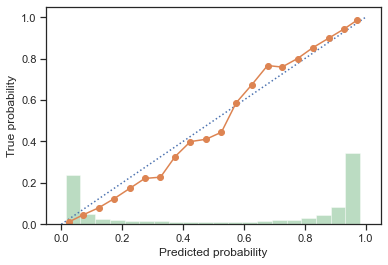

In [117]:
rf = RandomForestClassifier(random_state=0, n_estimators=25, max_depth=32, n_jobs=-1)
cc = CalibratedClassifierCV(rf, cv=3, method='sigmoid').fit(X_train, y_train)

plot_calibration_curve(X_test, y_test, cc, n_bins=20)

## Exercise 8: Gradient Boosting
Implement a function `evaluate_GB` that measures the performance of `GradientBoostingClassifier` or the `XGBoostClassifier` for 
different learning rates (0.01, 0.1, 1, and 10). As before, use a 3-fold cross-validation. You can use a 5% stratified sample of the whole dataset.
Finally plot the results for `n_estimators` ranging from 1 to 100. Run all the GBClassifiers with `random_state=1` to ensure reproducibility.

Implement a function that plots the score of `evaluate_GB` for `n_estimators` = 10,20,30,...,100 on a linear scale.

[ 10  20  30  40  50  60  70  80  90 100]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:26<00:00, 62.67s/it]


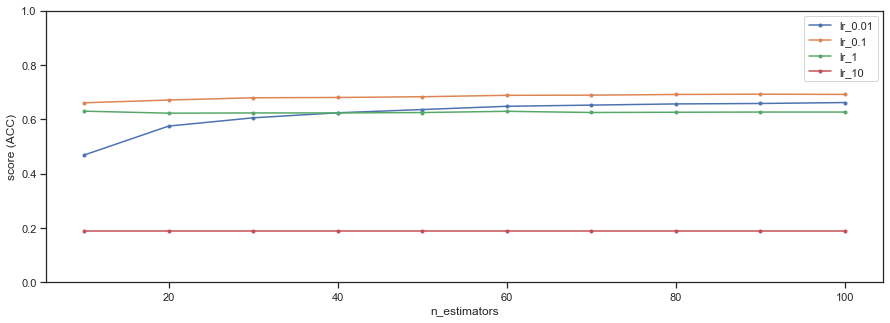

In [128]:
from sklearn.ensemble import GradientBoostingClassifier
GradientBoostingClassifier()

def evaluate_GB(X, y,n_estimators,score='accuracy', learning_rates = [0.01, 0.1, 1, 10]):
    results = {}
    for lr in learning_rates:
        gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=lr, random_state=1)
        results['lr_{}'.format(lr)] = np.mean(cross_val_score(gb, X, y, cv=3, scoring=score))
    
    return results

def plot_results_GB(X, y, score = "accuracy"):
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.05)
    
    fig, ax = fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    n_est_param = np.linspace(10,100, 10, dtype=int)
    plot_series = {}
    for n_est in tqdm(n_est_param):
        scores = evaluate_GB(Xs, ys, n_est, score=score)
        
        if len(plot_series.keys()) == 0:
            for k in scores.keys():
                plot_series[k] = [scores[k]]
        
        else:
            for k in scores.keys():
                plot_series[k].append(scores[k])

    
    for k in plot_series.keys():
        ax.plot(n_est_param, plot_series[k], marker = '.', label = k)
    ax.set_ylabel('score (ACC)')
    ax.set_ylim((0,1))
    ax.set_xlabel("n_estimators")
    ax.legend()
    

plot_results_GB(X, y)  

In general gradient boosting performance less well than random forests. Also, for too high learning rates the model performs less well with more estimators. This is likely because weights are adapted too much, therefore overcompensating mistakes of previous models and introducing more error. 